## TL streamfunction

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Data analysis and viz libraries
import aeolus.calc as acalc
import aeolus.calc.meta as ameta
import aeolus.coord as acoord
import aeolus.plot as aplt
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from windspharm.iris import VectorWind

In [3]:
# Local modules
import mypaths
import names
from calc import (
    hdiv,
    integral,
    mass_weighted_vertical_integral,
    meridional_mean,
    moist_static_energy,
    spatial_mean,
    vert_mer_mean_of_mse_flux,
    wind_rot_div,
    zonal_mean,
)
from grid import reverse_along_dim
from load_thai import LOAD_CONF
from plot_func import (
    KW_AUX_TTL,
    KW_AXGR,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    XLOCS,
    YLOCS,
    figsave,
    linspace_pm1,
)

In [4]:
def add_coord_system(cube, model_key, radius):
    model_names = getattr(names, model_key.lower())
    _coord_system = iris.coord_systems.GeogCS(
        semi_major_axis=radius, longitude_of_prime_meridian=0
    )
    for dim, standard_name in zip(["x", "y"], ["longitude", "latitude"]):
        dim_name = getattr(model_names, dim)
        try:
            cube.coord(dim_name).units = "degrees"
            cube.coord(dim_name).rename(standard_name)
            cube.coord(dim_name).coord_system = _coord_system
        except iris.exceptions.CoordinateNotFoundError:
            pass

In [5]:
def sf_const_factor(ds, model_key, const):
    model_names = getattr(names, model_key.lower())
    # Convert constants to iris cubes to preserve units
    RPLANET = iris.cube.Cube(const.rplanet_m, units="m")
    lat_cos_cube = np.cos(np.deg2rad(ds[model_names.y])).to_iris()
    lat_cos_cube.units = "1"
    add_coord_system(lat_cos_cube, model_key, float(RPLANET.data))
    # Constant factor outside the integral
    return 2 * np.pi * RPLANET * lat_cos_cube

In [6]:
plt.style.use("paper.mplstyle")

## Choose case

In [7]:
THAI_cases = ["Hab2"]

THAI_case = THAI_cases[0]

## Constants

Define atmospheric and planetary constants. Note the planet's radius is in meters!

In [8]:
if THAI_case.endswith("1"):
    import const_ben1_hab1 as const
else:
    import const_ben2_hab2 as const

## Loading the data

Load the time-averaged data previously preprocessed.

In [9]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# Loop over THAI cases (this loop can swapped places with the loop below if needed)
for THAI_case in THAI_cases:
    # for each of the THAI cases, create a nested directory for models
    datasets[THAI_case] = {}
    for model_key in LOAD_CONF.keys():
        model_names = getattr(names, model_key.lower())
        datasets[THAI_case][model_key] = xr.open_dataset(
            mypaths.datadir / model_key / f"{THAI_case}_time_mean_{model_key}.nc"
        )
    datasets[THAI_case]["ExoCAM"][names.exocam.lev].attrs.update(units="hPa")
    datasets[THAI_case]["ROCKE3D"][names.rocke3d.pres].attrs.update(units="hPa")
    datasets[THAI_case]["ROCKE3D"][names.rocke3d.lev].attrs.update(
        positive="up", units="1"
    )

In [10]:
new_lats = datasets[THAI_case]["UM"].latitude.values  # regrid to the UM grid
new_lons = datasets[THAI_case]["UM"].longitude.values
for THAI_case in THAI_cases:
    for model_key in LOAD_CONF.keys():
        if model_key == "UM":
            continue
        model_names = getattr(names, model_key.lower())
        ds = datasets[THAI_case][model_key]
        new_ds = {}
        for d in ds.data_vars:
            vrbl = ds[d]
            if (model_names.y in vrbl.dims) and (model_names.x in vrbl.dims):
                # print(model_key, vrbl.name)
                vrbl = vrbl.interp(
                    coords={
                        model_names.y: new_lats,
                        model_names.x: new_lons,
                    },
                    kwargs={"fill_value": "extrapolate"},
                )
                new_ds[d] = vrbl
        datasets[THAI_case][model_key] = xr.Dataset(new_ds)

In [11]:
@ameta.update_metadata(name="tidally_locked_streamfunction", units="1e11 kg s-1")
def tl_streamfunction(ds, model_key, const, truncation=None):
    model_names = getattr(names, model_key.lower())
    # Convert constants to iris cubes to preserve units
    RGAS = iris.cube.Cube(const.rgas, units="J kg-1 K-1")
    RPLANET = iris.cube.Cube(const.rplanet_m, units="m")
    GPLANET = iris.cube.Cube(const.gplanet, units="m s-2")
    # Convert data arrays to iris cubes
    u_cube = ds[model_names.u].to_iris()
    v_cube = ds[model_names.v].to_iris()
    temp_cube = ds[model_names.temp].to_iris()
    pres_cube = ds[model_names.pres].to_iris()
    pres_cube.convert_units("Pa")
    # Make the lon/lat coordinates CF-compliant
    for cube in [u_cube, v_cube, pres_cube, temp_cube]:
        add_coord_system(cube, model_key, float(RPLANET.data))
    rho_cube = pres_cube / (RGAS * temp_cube)
    # Calculate divergent components of the wind
    vec = VectorWind(u_cube, v_cube, rsphere=float(RPLANET.data))
    u_cube, v_cube = vec.irrotationalcomponent(truncation=truncation)
    # Transform to tidally-locked coordinates
    _, v_tl_cube = acalc.rotate_winds_to_tidally_locked_coordinates(u_cube, v_cube)
    v_tl_cube = acalc.regrid_to_tidally_locked_coordinates(v_tl_cube)
    v_tl_zm = acalc.zonal_mean(v_tl_cube)
    rho_tl_zm = acalc.zonal_mean(acalc.regrid_to_tidally_locked_coordinates(rho_cube))
    # Calculate the integral
    if model_key == "ExoCAM":
        # alt_cube = ds[model_names.z].to_iris()
        # add_coord_system(alt_cube, model_key, float(rplanet.data))
        # alt_tl_zm = acalc.zonal_mean(acalc.regrid_to_tidally_locked_coordinates(alt_cube))
        # dzdp = acalc.deriv(alt_tl_zm, "atmosphere_hybrid_sigma_pressure_coordinate")
        sf_tl = -1 * acalc.cumsum(v_tl_zm, "z", True) / GPLANET
    elif model_key == "LMDG":
        sf_tl = acalc.cumsum(v_tl_zm * rho_tl_zm, "z", True)
    elif model_key == "ROCKE3D":
        # ysub = slice(None, None)
        alt_cube = ds[model_names.z].to_iris()
        add_coord_system(alt_cube, model_key, float(RPLANET.data))
        alt_tl_zm = acalc.zonal_mean(
            acalc.regrid_to_tidally_locked_coordinates(alt_cube)
        )
        dzdp = acalc.deriv(alt_tl_zm, model_names.lev)
        sf_tl = acalc.cumsum(v_tl_zm * rho_tl_zm * dzdp, "z", True)
    elif model_key == "UM":
        sf_tl = acalc.cumsum(v_tl_zm * rho_tl_zm, "z", True)
    sf_tl *= sf_const_factor(ds, model_key, const)
    return sf_tl

In [12]:
VRBLS = {}
for THAI_case in THAI_cases:
    VRBLS[THAI_case] = {}
    for model_key in LOAD_CONF.keys():
        model_names = getattr(names, model_key.lower())
        VRBLS[THAI_case][model_key] = {}
        VRBLS[THAI_case][model_key]["sf_tl"] = tl_streamfunction(datasets[THAI_case][model_key], model_key, const=const)
        _pres = datasets[THAI_case][model_key][model_names.pres].to_iris()
        _pres.convert_units("hPa")
        add_coord_system(_pres, model_key, const.rplanet_m)
        VRBLS[THAI_case][model_key]["mean_pres"] = acalc.spatial_mean(_pres)

In [13]:
kw_plt = dict(levels=linspace_pm1(6) * 6, cmap="coolwarm", extend="both")

Saved to ../plots/Hab2__tl_sf.png


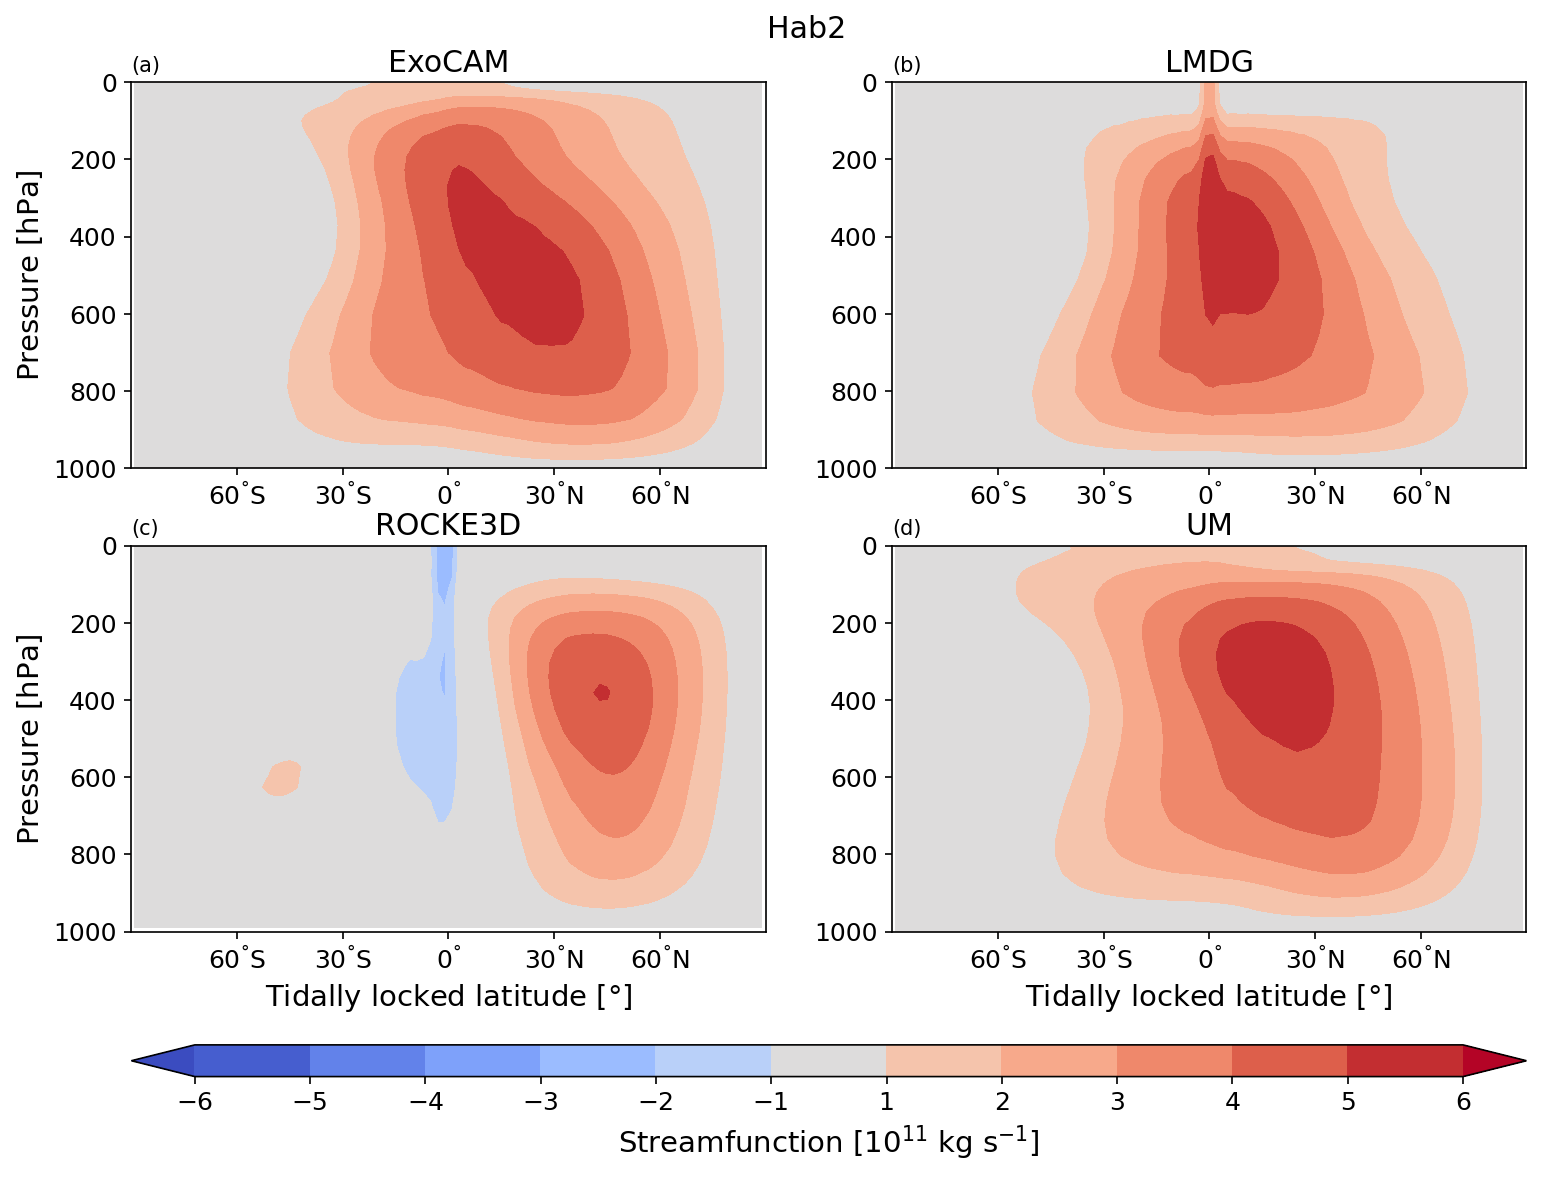

In [14]:
ncols = 2
nrows = 2
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(6 * ncols, 5 * nrows), squeeze=False
)

iletters = aplt.subplot_label_generator()
for model_key, ax in zip(LOAD_CONF.keys(), axs.flat):
    model_names = getattr(names, model_key.lower())
    cube = VRBLS[THAI_case][model_key]["sf_tl"]
    ypoints = cube.coord(model_names.y).points
    zpoints = VRBLS[THAI_case][model_key]["mean_pres"].data
    arr = cube.data
    cntrf = ax.contourf(ypoints, zpoints, arr, **kw_plt)
    ax.set_title(f"({next(iletters)})", **KW_SBPLT_LABEL)
    ax.set_title(model_key, **KW_MAIN_TTL)
    ax.set_ylim(1000, 0)
    ax.set_xlim(-90, 90)
    ax.set_xticks(YLOCS[1:-1])
    ax.set_xticklabels([aplt.fmt_lonlat(i, "lat", True) for i in YLOCS[1:-1]])
    if ax.is_first_col():
        ax.set_ylabel("Pressure [$hPa$]")
    if ax.is_last_row():
        ax.set_xlabel("Tidally locked latitude [$\degree$]")
    # ax.set_yscale("symlog")
cbar = fig.colorbar(cntrf, ax=axs, pad=0.1, orientation="horizontal", aspect=40)
cbar.ax.set_xlabel("Streamfunction [$10^{11}$ $kg$ $s^{-1}$]")
cbar.set_ticks(linspace_pm1(6) * 6)
fig.suptitle(f"{THAI_case}", x=0.5, y=0.925)
figsave(fig, mypaths.plotdir / f"{THAI_case}__tl_sf")

In [15]:
# lons = v_tl_cube.coord(model_names.x).points
# lats = v_tl_cube.coord(model_names.y).points
# lons2d, lats2d = np.meshgrid(lons, lats)
# skip = slice(None, None, 1), slice(None, None, 1)

# iz = 35
# plt.subplot(211)
# plt.title(u_cube.coord("level").points[iz])
# plt.contourf(
#     lons,
#     lats,
#     (u_cube.data[iz, ...][ysub, :] ** 2 + v_cube.data[iz, ...][ysub, :] ** 2) ** 0.5,
# )
# plt.colorbar()
# plt.quiver(
#     lons2d[skip],
#     lats2d[skip],
#     u_cube.data[iz, ...][ysub, :][skip],
#     v_cube.data[iz, ...][ysub, :][skip],
# )

# plt.subplot(212)
# plt.contourf(
#     lons, lats, (u_tl_cube.data[iz, ...] ** 2 + v_tl_cube.data[iz, ...] ** 2) ** 0.5
# )
# plt.colorbar()
# plt.quiver(
#     lons2d[skip],
#     lats2d[skip],
#     u_tl_cube.data[iz, ...][skip],
#     v_tl_cube.data[iz, ...][skip],
# )